In [1]:
%autosave 0
from datetime import date
import os

Autosave disabled


In [2]:
import funcy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", size=22)

In [3]:
!ls output/mean/analysis

counts_mean_pct.tex		planning_times_imputedb.csv
counts_mean.tex			running_times_base_tables_1.csv
counts_std.tex			running_times_base_tables.csv
perf_summary.tex		running_times_imputedb_1.csv
planning_times_base_tables.csv	running_times_imputedb.csv


In [4]:
# Load data
def load_data(kind, name, subdir=""):
    df = pd.read_csv(os.path.join("output", subdir, "{}_{}_1.csv".format(kind, name)), index_col=0)
    return df

nqueries = 9
times = {}
for method in ["mean", "hot_deck", "regression_tree"]:
    subdir = os.path.join(method, "analysis")
    times[method] = {}
    for scale in ["imputedb", "base_tables"]:
        times[method][scale] = load_data("running_times", scale, subdir)
        
    times[method]["combined"] = times[method]["base_tables"].append(times[method]["imputedb"])

In [5]:
# Round alpha to nearest 0.05
def round_alpha(alpha):
    if alpha == "Impute at base tables":
        return "Impute at base tables"
    else:
        return round(alpha * 100 / 5) / (100 / 5)
    
for method in ["mean", "hot_deck", "regression_tree"]:
    for scale in ["imputedb", "base_tables", "combined"]:
        times[method][scale]["alpha"] = times[method][scale]["alpha"].apply(round_alpha)

In [6]:
times["regression_tree"]["base_tables"].head()

,query,alpha,mean,std
0,0.0,Impute at base tables,24935.606818,5549.724521
1,1.0,Impute at base tables,6553.513636,50.731587
2,2.0,Impute at base tables,10650.927273,49.561771
3,3.0,Impute at base tables,10652.572727,58.008496
4,4.0,Impute at base tables,10646.022727,51.340162


In [7]:
times["regression_tree"]["imputedb"].head()

,query,alpha,mean,std
0,0.0,0.0,708.127273,312.209595
1,0.0,0.5,324.595455,150.178299
2,0.0,1.0,18.636364,5.430828
3,1.0,0.0,556.231818,11.419997
4,1.0,0.5,94.227273,2.738726


In [8]:
def plot(times, method):
    df = times[method]["combined"].copy()
    kind = "running_times"
    name = "combined"
    
    # plots
    xticks = range(0, nqueries)
    xlabels = ["%i" % (q + 1) for q in xticks]
    
    f = plt.figure()

    df = df.pivot(index="query",columns="alpha",values="mean")
    df = df[["Impute at base tables",0.0,0.5,1.0]]
    df = df.rename(columns={
        0.0: r"$\alpha = 0.0$",
        0.5: r"$\alpha = 0.5$",
        1.0: r"$\alpha=1.0$",
        "Impute at base tables" : "Baseline"
    })
    ax = df.plot(kind="bar")
    ax.set_yscale("log")
    ax.set_ylim(bottom=0.99, top=10e5-0.1)
    ax.legend(title=None, loc="upper left", fontsize=14, ncol=2)
    ax.title.set_fontsize(16)

    xticks = range(0, len(df))
    xlabels = ["%i" % (q + 1) for q in xticks]
    plt.xlim(xticks[0] - 1, xticks[-1] + 1)
    plt.xticks(xticks, xlabels, rotation=0)

    plt.xlabel("Query")
    plt.ylabel("Running Time (ms)")

    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

    dt = date.today().isoformat()
    nm = os.path.join("output/{}".format(method), "{}_{}_bar_{}_{}".format(kind, name, method, dt))
    
    normal_params = {"bbox_inches": "tight", "dpi": 1200}
    plot_list = [
        (".png", normal_params),
        ("_transparent.png", funcy.merge(normal_params, {"transparent": True})),
        (".eps", normal_params),
    ]
    for suffix, params in plot_list:
        plt.savefig(nm + suffix, **params)
    df.to_csv(nm + ".csv")
    
    return f

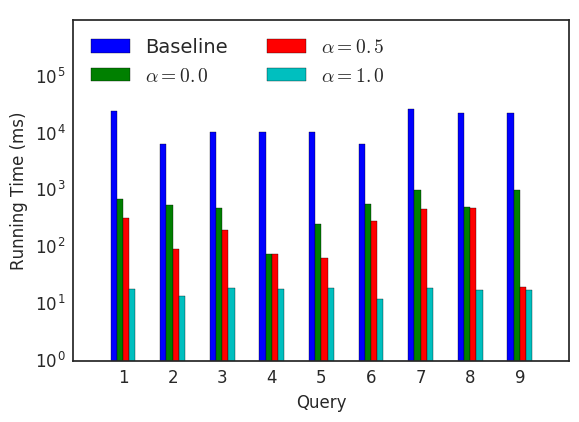

In [9]:
f = plot(times, "regression_tree")

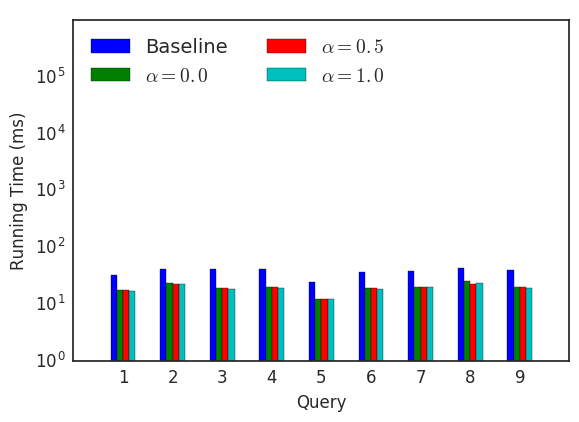

In [10]:
f = plot(times, "mean")

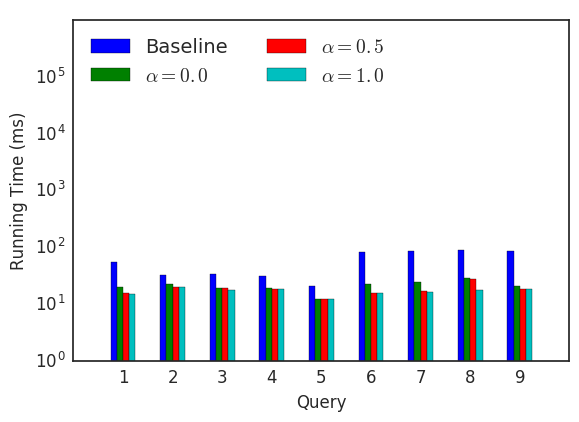

In [11]:
f = plot(times, "hot_deck")